## About

This is a small introduction to using TSNE in python. It has been built as a suplementary lecture for BIOS8366 (Advanced Statistical Computing) at Vanderbilt University for the Fall 2018 semester. It is indended to follow the introduction to the TSNE algorithm as presented [here](https://beta.observablehq.com/@nstrayer/t-sne-explained-in-plain-javascript). 

A large amount of the code here has been adopted from the wondeful introduction of a similair vein of [Introduction to  t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne) written by Manish Pathak on the DataCamp blog. 


## Packages! 

First we start by loading a whole bunch of packages that will allow us to run our algorithms and plot them. 

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 42

## Data

For the sake of consistancy we will use the [wine]('https://raw.githubusercontent.com/fonnesbeck/Bios8366/master/data/wine.dat') dataset we've used throughout the course. Here we load it and pop off the grape labels like we've done in the past. 

In [0]:
wine = pd.read_table('https://raw.githubusercontent.com/fonnesbeck/Bios8366/master/data/wine.dat', sep='\s+')
grape = wine.pop('region') - 1

In [3]:
wine.values.shape

(178, 13)

We've got 178 observations of 13 different variables. This is on the small end for TSNE but obviously we're not capable of making a 13 dimensional scatter plot so we should get some value out of this. 

## Plotting Function

Next we will define a function that allows us to easily plot the results of our transformation and superimpose the underlying labels on top of the points. No need to really dig into this function. 

In [0]:
def labeled_scatter(x, labels):
  
  # choose a color palette with seaborn.
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette("hls", num_classes))

  # create a scatter plot.
  f = plt.figure(figsize=(8, 8))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[labels])
  plt.xlim(-25, 25)
  plt.ylim(-25, 25)
  ax.axis('off')
  ax.axis('tight')

  # add the labels for each digit corresponding to the label
  txts = []

  for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[labels == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


  return f, ax, sc, txts


## A Baseline

Whenever we desire to use a fancy algorithm like TSNE we should usually try the easiest method first. In the case of TSNE this is PCA. 

PCA is the original dimensionality reduction technique. It attempts to rotate the data in its k-dimensional space such that the most variance is captured in the first dimension, the most of the remaining in the second...etc and so on. This is very simplistic but offers many nice benefits over TSNE such as the ability to run a 'learned' dimensionality reduction on new data. 

In [0]:
from sklearn.decomposition import PCA

wine_pca = PCA(n_components=2).fit_transform(wine.values)

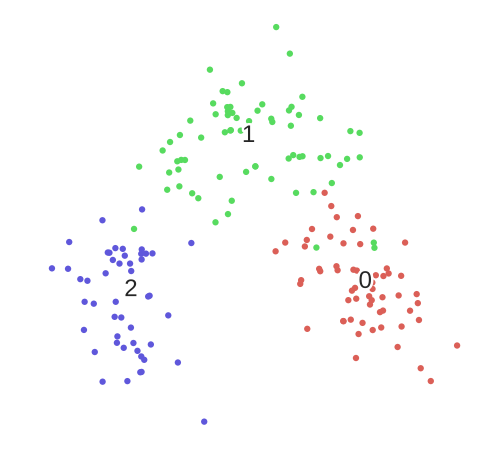

In [6]:
labeled_scatter(wine_pca, grape);

## TSNE

Now we can get to the good stuff. Luckily, TSNE is included in `sklearn.manifold` and follows the same `sklearn` pattern we know and love. 

Because we have a relatively small amount of data we will lower the perplecity to `10` from the default `30`. 

In [0]:
from sklearn.manifold import TSNE

wine_tsne = TSNE(random_state=RS, perplexity = 10).fit_transform(wine.values)

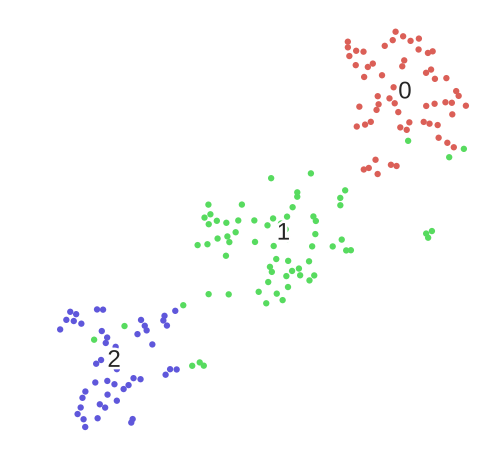

In [0]:
labeled_scatter(wine_tsne, grape);

We definitely get some good separation here that we didn't see in the PCA.

We do however, see some points that are almost 'misclassified' and put into the clusters for another grape type. PCA while it didn't provide as great of separation, does provide a slightly more consistant placements. Again, this data is probably not ideal for TSNE. 

## A bonus: UMAP

A newcomer to this world is the algorithm __UMAP__, which stands for __U__niform __M__anifold __A__proximation and __P__rojection. At least for me, the math behind it is more complicated than TSNE but ultimately it attempts to locate high-dimensional manifolds and unravel them to plotting. 

It has a few strong benefits over TSNE: 
1. It learns a mapping that _can_ be applied to new data. 
2. It's super fast. 

It's not installed directly on collaboratory, but we can easily pip install it. (Note that the package name is `umap-learn` not `umap`.)

In [0]:
!pip install umap-learn

In [0]:
import umap

wine_umap = umap.UMAP(random_state = RS).fit_transform(wine.values)

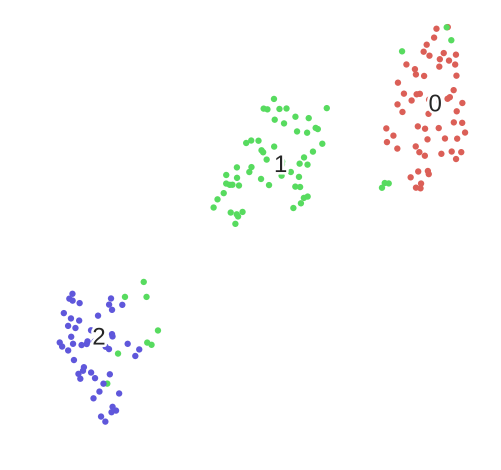

In [0]:
labeled_scatter(wine_umap, grape);

---
## Bonus bonus

As mentioned before, the wine dataset is rather low-dimensional in the scheme of TSNE. In attempt to better show the power of TSNE over PCA let's look at a much higher dimensional dataset. 

Fashion MNIST is a set of images of various fashion items that is commonly used to test computer vision algorithms. The data comes in the form of 28x28 pixel images of 10 different classes. While the best algorithms for this dataset would take into account the spatial correlation of the pixels, we can still treat this 28x28 image as an unraveled 784 dimensional vector. 

![](https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s1600/out.jpg)

Fashion MNIST is conveniently provided in Tensorflow, so we can just grab it from there to load it. 

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


We need to reshape the images to a 1d vector of unraveled pictures instead of the 2d image we started with. Byebye helpful spatial correlations! We will also lower the number of images we pull to 3000 images as things can take a good amount of time on the full 60,000 images!

In [0]:
subset_size = 3000
x_train = x_train.reshape(60000, 784)[:subset_size]
y_train = y_train[:subset_size]

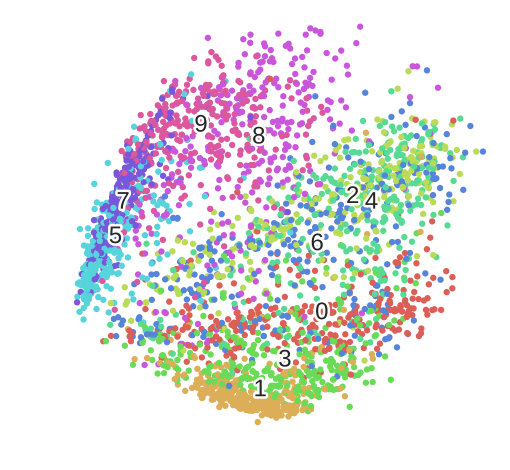

In [0]:
fashion_pca = PCA(n_components=2).fit_transform(x_train)
labeled_scatter(fashion_pca,y_train); 

In [0]:
# This will take a bit of time
fashion_tsne = TSNE(random_state=RS).fit_transform(x_train)

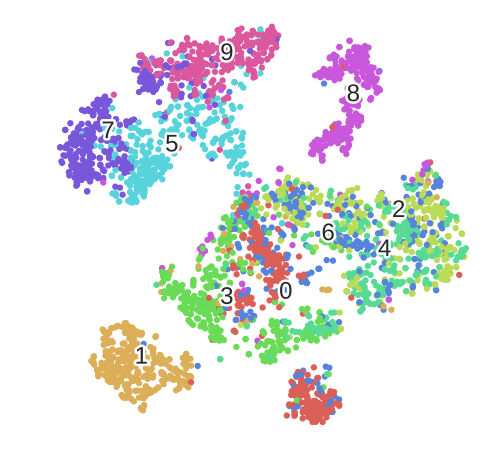

In [0]:
labeled_scatter(fashion_tsne, y_train);

In [0]:
# Much much faster than tsne. 
fashion_umap = umap.UMAP(random_state = RS).fit_transform(x_train)

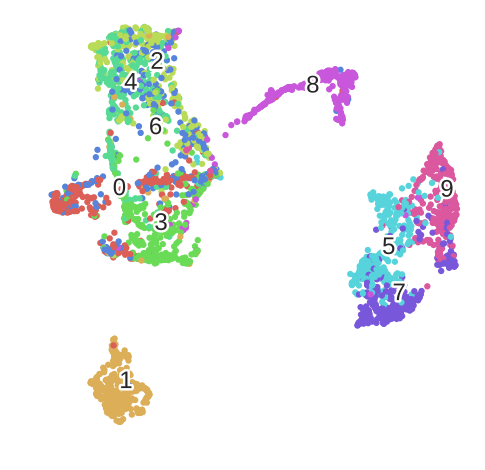

In [0]:
labeled_scatter(fashion_umap, y_train);